# Phase 1 vs. Phase 1 Volcano Plots

using results from [deseq_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb) to generate publication-formatted volcano plots

## 0. load libraries

In [2]:
library(tidyverse) # for ggplot and dplyr
library(cowplot) # for combining plots

## 1. load CSVs and write DEGs csv

In [3]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes',
    pattern = '\\.csv$',
    full.names = TRUE
    )

head(files)

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/hypoxic_v_normoxic.csv"
[2] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.both_v_cont.csv"    
[3] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.hyp_v_both.csv"     
[4] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.hyp_v_cont.csv"     
[5] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.hyp_v_warm.csv"     
[6] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/all_genes/p1.warm_v_both.csv"

The order of oyster treatment is intential - the oyster listed second is the 'baseline' from DESeq. In other words, If the file name is both_v_cont.csv, then the LFC values are for B in relation to C (a +lfc = more expression in B, a -lfc = more expression in C)

I want to read in a csv, assign directionality to DEGs (or mark genes as not significant)

In [4]:
deg_list <- lapply(files, function(f) {

  df <- read.csv(f)

  # remove extension
  name <- tools::file_path_sans_ext(basename(f))
  # "p1.hyp_v_cont"

  # remove prefix up to first dot
  name2 <- sub("^.*\\.", "", name)
  # "hyp_v_cont"

  # split on _v_
  groups <- strsplit(name2, "_v_")[[1]]
    
    g1 <- substr(toupper(groups[1]), 1, 1)  # H
    g2 <- substr(toupper(groups[2]), 1, 1)  # C

  # comparison label (H vs. C)
  df$pair <- paste(g2, "vs.", g1)

  df$DEG_group <- "NS"
  df$DEG_group[df$padj < 0.05 & df$log2FoldChange >  1] <- g1
  df$DEG_group[df$padj < 0.05 & df$log2FoldChange < -1] <- g2

  df
})



In [5]:
# assigning names to deg_list to be able to call downstream
file_names <- tools::file_path_sans_ext(basename(files))

groups <- sub("^.*\\.", "", file_names) |>     # remove prefix
          strsplit("_v_")

names(deg_list) <- sapply(groups, function(x) {
  paste0(
    substr(x[1], 1, 1),
    "_",
    substr(x[2], 1, 1)
  ) |> tolower()
})


In [6]:
names(deg_list)

head(deg_list$b_c)

[1] "h_n" "b_c" "h_b" "h_c" "h_w" "w_b" "w_c" "w_a"

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111116054,8.739763,0.003918627,0.08851593,0.6101687,0.5417500,0.9863770,0.9689312,C vs. B,NS
2,LOC111126949,670.509082,0.001028526,0.04325616,0.2542243,0.7993223,0.9996341,0.9797357,C vs. B,NS
3,LOC111110729,160.018313,0.001896209,0.02965754,0.5218944,0.6017438,0.9904983,0.9837408,C vs. B,NS
4,LOC111112434,13.048074,-0.004022699,0.07571792,-0.7249581,0.4684777,0.9769627,0.9707931,C vs. B,NS
5,LOC111120752,403.233517,-0.001715556,0.04025490,-0.4217741,0.6731899,0.9973811,0.9807015,C vs. B,NS
6,LOC111128944,1.594569,-0.037626875,0.40747170,-1.2372060,0.2160106,NA,0.8555551,C vs. B,NS


writing out *only* DEGs for downstream analysis

In [9]:
out_dir <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/DEGs"  

for (nm in names(deg_list)) {

  df <- deg_list[[nm]]

  deg_df <- df[!is.na(df$DEG_group) & df$DEG_group != "NS", ]

  write.csv(
    deg_df,
    file = file.path(out_dir, paste0("DEG_", nm, ".csv")),
    row.names = FALSE
  )
}


## 2. ggplot

### comparisons vs. control

In [7]:
cont_only <- rbind(deg_list$w_c, deg_list$h_c, deg_list$b_c)

head(cont_only)
tail(cont_only)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111116054,8.739763,0.0074950539,0.10558225,0.74682942,0.45516653,0.9628155,0.9807342,C vs. W,NS
2,LOC111126949,670.509082,-0.0008413897,0.06985369,-0.07440747,0.94068617,0.9983738,0.9884736,C vs. W,NS
3,LOC111110729,160.018313,-0.0659273575,0.13361268,-2.17370214,0.02972751,0.5352822,0.9883602,C vs. W,NS
4,LOC111112434,13.048074,-0.0124548917,0.10906392,-1.10600106,0.26872606,0.8946927,0.9790219,C vs. W,NS
5,LOC111120752,403.233517,0.0128102382,0.07701767,0.96151858,0.33629149,0.9266293,0.9876052,C vs. W,NS
6,LOC111128944,1.594569,-0.0034572083,0.17695745,-0.28291702,0.77724045,NA,0.9760533,C vs. W,NS


,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
116509,ND4,232675.09,0.0035076866,0.03907737,0.81339031,0.4159943,0.9666491,0.9820183,C vs. B,NS
116510,ND5,214539.99,0.0032719566,0.03521552,0.79695059,0.4254797,0.9691481,0.9831433,C vs. B,NS
116511,ND6,76772.90,-0.0090421164,0.05669678,-1.49027401,0.1361522,0.8197271,0.9803237,C vs. B,NS
116512,ND3,32972.87,0.0005374793,0.02931655,0.14986515,0.8808710,0.9996341,0.9836689,C vs. B,NS
116513,ND1,180539.68,0.0008220359,0.02932811,0.22894881,0.8189087,0.9996341,0.9836538,C vs. B,NS
116514,ND4L,10161.78,-0.0002947959,0.03240109,-0.07828084,0.9376047,0.9996341,0.9831833,C vs. B,NS


Warning message:
“Removed 20674 rows containing missing values or values outside the scale range
(`geom_point()`).”


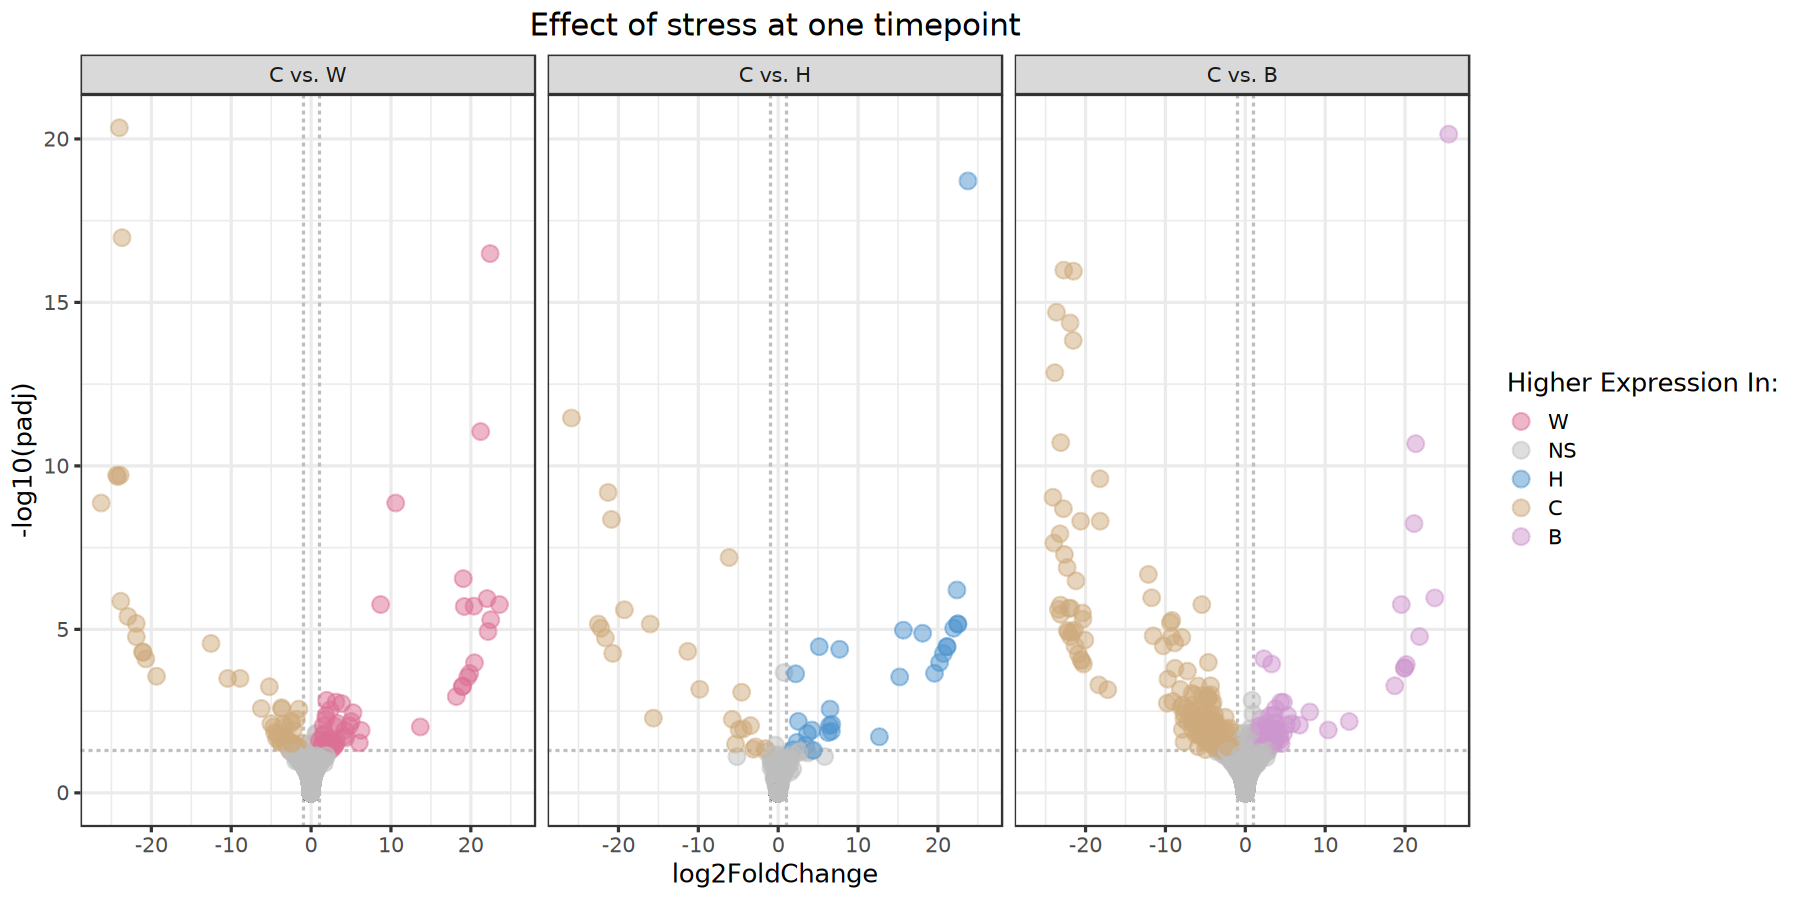

In [8]:
options(repr.plot.width=15, repr.plot.height=7.5)

# Specify the order for plots to follow Sophie's order
cont_only$pair <- factor(cont_only$pair, levels = c("C vs. W", "C vs. H", "C vs. B"))


cont_only.plot <- ggplot(data = cont_only,
                     aes(x = log2FoldChange,
                         y = -log10(padj),
                         col = DEG_group)) +
# fold change threshold line
geom_vline(xintercept = c(-1, 1), 
           col = "gray",
           linetype = "dashed") +
# adjusted p-value line
geom_hline(yintercept = -log10(0.05),
           col = "gray",
           linetype = "dashed") +
scale_color_manual(values = c("H" = "steelblue3", "W" = "palevioletred", "C" = "burlywood3", "B" = "plum3", "NS" = "grey")) +
facet_wrap(~pair) +
geom_point(size=4, alpha = 0.5) +
theme_bw(base_size = 15) +
theme(plot.title = element_text(hjust=.5)) + 
labs(col = 'Higher Expression In:',
    title = 'Effect of stress at one timepoint') +
guides(col = guide_legend(reverse = TRUE))

cont_only.plot

In [16]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/vs.control_volcano.pdf', cont_only.plot, width=15, height=7.5)

Warning message:
“Removed 20674 rows containing missing values or values outside the scale range
(`geom_point()`).”


### other comparisons

In [9]:
other_comp <- rbind(deg_list$w_b, deg_list$h_b, deg_list$h_w)

head(other_comp)
tail(other_comp)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111116054,8.739763,0.001829289,0.1307206,0.1033095,0.917717303,0.9921758,0.9802539,B vs. W,NS
2,LOC111126949,670.509082,-0.009479291,0.1151300,-0.3251544,0.745064231,0.9719153,0.9846577,B vs. W,NS
3,LOC111110729,160.018313,-0.144957580,0.1412530,-2.5948696,0.009462682,0.2969110,0.9821668,B vs. W,NS
4,LOC111112434,13.048074,-0.006558019,0.1264564,-0.3309783,0.740660876,0.9715949,0.9805550,B vs. W,NS
5,LOC111120752,403.233517,0.046724284,0.1212904,1.3383040,0.180797353,0.7534842,0.9819196,B vs. W,NS
6,LOC111128944,1.594569,0.019393191,0.2786881,0.9673838,0.333352189,NA,0.9396585,B vs. W,NS


,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
116509,ND4,232675.09,-0.02476369,0.1318265,-0.3782561,0.7052403,0.9513565,0.9895490,W vs. H,NS
116510,ND5,214539.99,-0.02289861,0.1239763,-0.3309860,0.7406551,0.9588647,0.9901777,W vs. H,NS
116511,ND6,76772.90,0.05131094,0.1310614,0.7595518,0.4475225,0.8804351,0.9893982,W vs. H,NS
116512,ND3,32972.87,0.05110589,0.1265578,0.7370438,0.4610957,0.8850250,0.9897373,W vs. H,NS
116513,ND1,180539.68,-0.02493231,0.1243890,-0.3609827,0.7181124,0.9551121,0.9901494,W vs. H,NS
116514,ND4L,10161.78,-0.04792145,0.1339794,-0.7266237,0.4674565,0.8874446,0.9891631,W vs. H,NS


Warning message:
“Removed 23882 rows containing missing values or values outside the scale range
(`geom_point()`).”


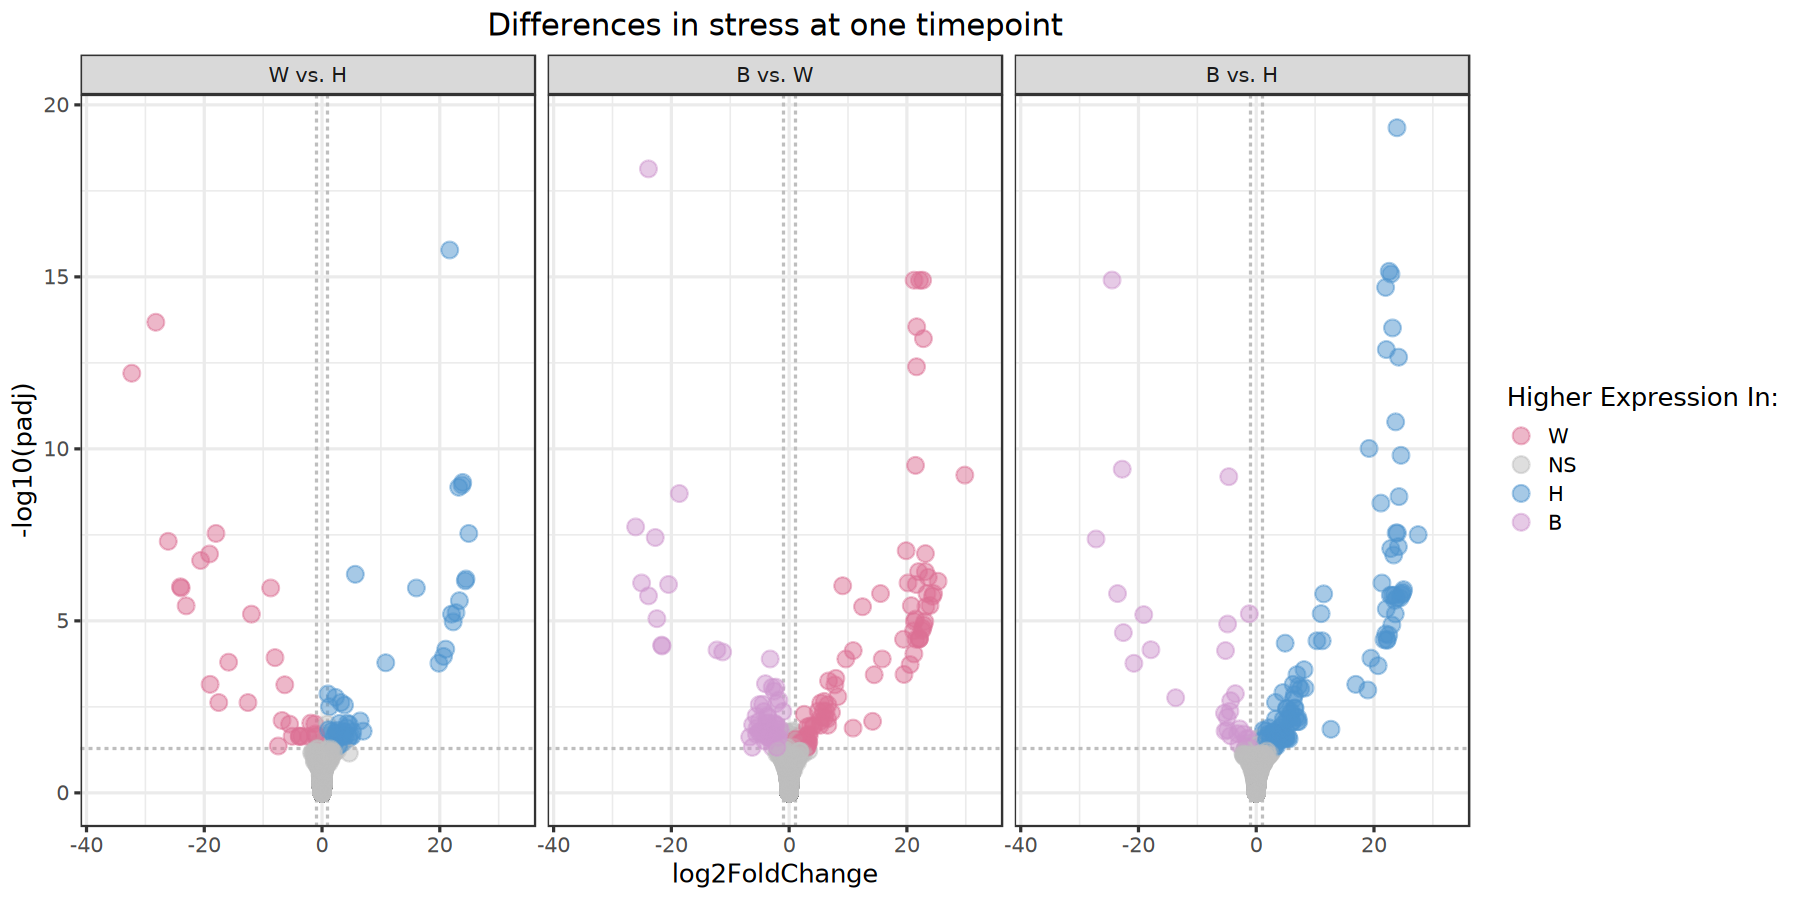

In [15]:
options(repr.plot.width=15, repr.plot.height=7.5)

# Specify the order for plots to follow Sophie's order
other_comp$pair <- factor(other_comp$pair, levels = c("W vs. H", "B vs. W", "B vs. H"))


other_comp.plot <- ggplot(data = other_comp,
                     aes(x = log2FoldChange,
                         y = -log10(padj),
                         col = DEG_group)) +
# fold change threshold line
geom_vline(xintercept = c(-1, 1), 
           col = "gray",
           linetype = "dashed") +
# adjusted p-value line
geom_hline(yintercept = -log10(0.05),
           col = "gray",
           linetype = "dashed") +
scale_color_manual(values = c("H" = "steelblue3", "W" = "palevioletred", "B" = "plum3", "NS" = "grey")) +
facet_wrap(~pair) +
geom_point(size=4, alpha = 0.5) +
theme_bw(base_size = 15) +
theme(plot.title = element_text(hjust=.5)) + 
labs(col = 'Higher Expression In:',
    title = 'Differences in stress at one timepoint') +
guides(col = guide_legend(reverse = TRUE))

other_comp.plot

In [31]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/vs.other_volcano.pdf', other_comp.plot, width=15, height=7.5)

Warning message:
“Removed 23882 rows containing missing values or values outside the scale range
(`geom_point()`).”


### everything together

In [13]:
all_comps <- rbind(cont_only, other_comp)
head(all_comps)
tail(all_comps)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,LOC111116054,8.739763,0.0074950539,0.10558225,0.74682942,0.45516653,0.9628155,0.9807342,C vs. W,NS
2,LOC111126949,670.509082,-0.0008413897,0.06985369,-0.07440747,0.94068617,0.9983738,0.9884736,C vs. W,NS
3,LOC111110729,160.018313,-0.0659273575,0.13361268,-2.17370214,0.02972751,0.5352822,0.9883602,C vs. W,NS
4,LOC111112434,13.048074,-0.0124548917,0.10906392,-1.10600106,0.26872606,0.8946927,0.9790219,C vs. W,NS
5,LOC111120752,403.233517,0.0128102382,0.07701767,0.96151858,0.33629149,0.9266293,0.9876052,C vs. W,NS
6,LOC111128944,1.594569,-0.0034572083,0.17695745,-0.28291702,0.77724045,NA,0.9760533,C vs. W,NS


,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
233023,ND4,232675.09,-0.02476369,0.1318265,-0.3782561,0.7052403,0.9513565,0.9895490,W vs. H,NS
233024,ND5,214539.99,-0.02289861,0.1239763,-0.3309860,0.7406551,0.9588647,0.9901777,W vs. H,NS
233025,ND6,76772.90,0.05131094,0.1310614,0.7595518,0.4475225,0.8804351,0.9893982,W vs. H,NS
233026,ND3,32972.87,0.05110589,0.1265578,0.7370438,0.4610957,0.8850250,0.9897373,W vs. H,NS
233027,ND1,180539.68,-0.02493231,0.1243890,-0.3609827,0.7181124,0.9551121,0.9901494,W vs. H,NS
233028,ND4L,10161.78,-0.04792145,0.1339794,-0.7266237,0.4674565,0.8874446,0.9891631,W vs. H,NS


Warning message:
“Removed 44556 rows containing missing values or values outside the scale range
(`geom_point()`).”


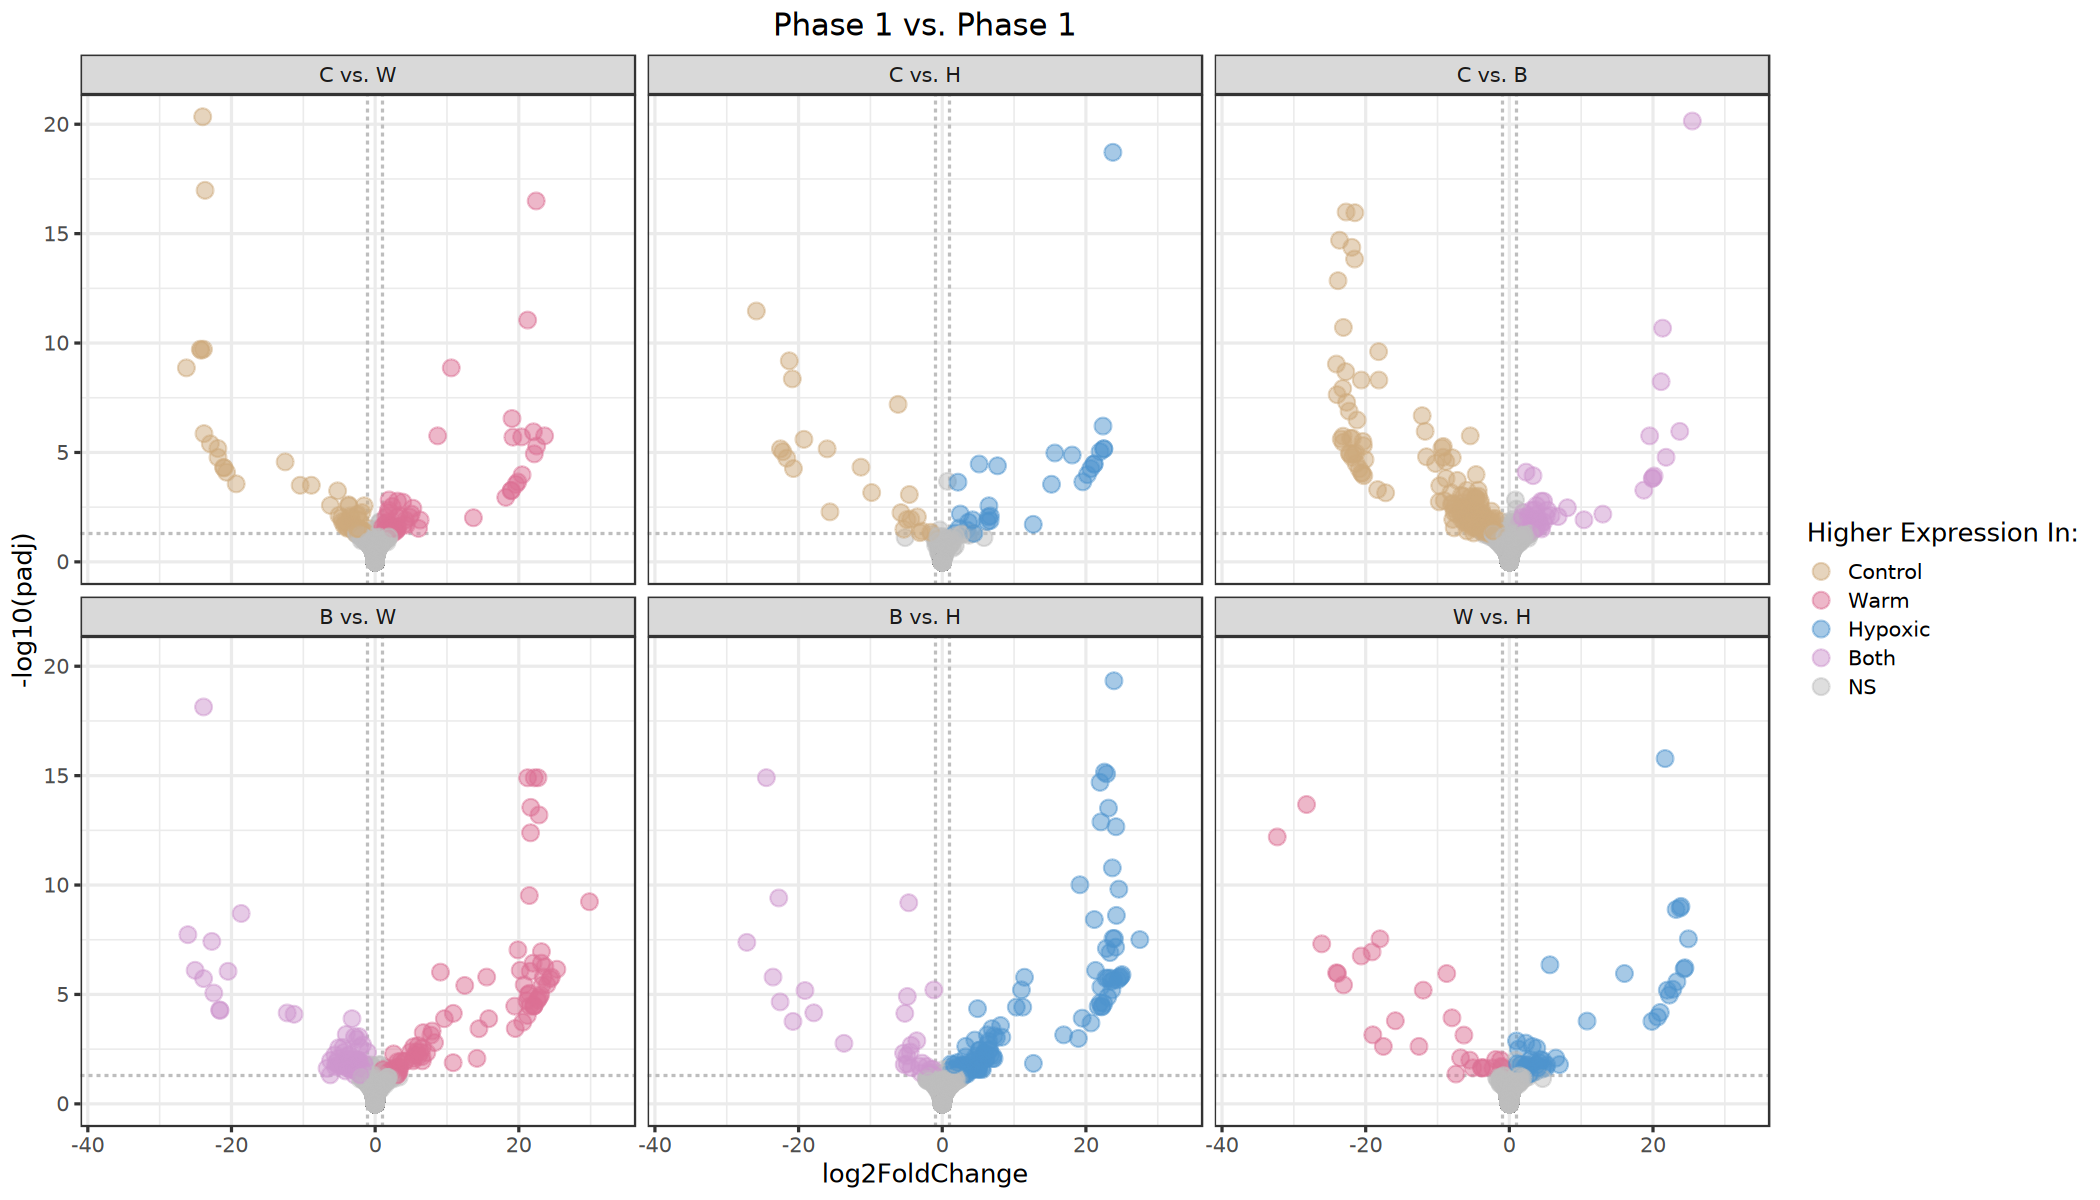

In [26]:
options(repr.plot.width=17.5, repr.plot.height=10)

# Specify the order for plots to follow Sophie's order
all_comps$pair <- factor(all_comps$pair, levels = c("C vs. W",
                                                    "C vs. H",
                                                    "C vs. B",
                                                    "B vs. W",
                                                    "B vs. H",
                                                   "W vs. H"))

# reorder appearance of treatments in legend
all_comps$DEG_group <- factor(all_comps$DEG_group, levels = c('C', 'W', 'H', 'B', 'NS'))


all_comp.plot <- ggplot(data = all_comps,
                     aes(x = log2FoldChange,
                         y = -log10(padj),
                         col = DEG_group)) +
# fold change threshold line
geom_vline(xintercept = c(-1, 1), 
           col = "gray",
           linetype = "dashed") +
# adjusted p-value line
geom_hline(yintercept = -log10(0.05),
           col = "gray",
           linetype = "dashed") +
scale_color_manual(values = c("C" = "burlywood3", "H" = "steelblue3", "W" = "palevioletred", "B" = "plum3", "NS" = "grey"), 
                  labels = c('Control', 'Warm', 'Hypoxic', 'Both', 'NS')) +
facet_wrap(~pair) +
geom_point(size=4, alpha = 0.5) +
theme_bw(base_size = 15) +
theme(plot.title = element_text(hjust=.5)) + 
labs(col = 'Higher Expression In:',
    title = 'Phase 1 vs. Phase 1') +
guides(col = guide_legend(reverse = FALSE))

all_comp.plot

In [27]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/all.comp_volcano.pdf', all_comp.plot, width = 17.5, height = 10)

Warning message:
“Removed 44556 rows containing missing values or values outside the scale range
(`geom_point()`).”


## 3. DEGs barplots
***only for comparisons with control***

In [40]:
cont_bar.df <- cont_only %>%
filter(DEG_group != 'NS') %>% # only want DEGs
mutate(up_down = case_when(
    DEG_group == 'C' ~ 'Down', # down-regulated when the DEG-group is C
    TRUE ~ 'Up' # up-regulated when not C
    ) )

head(cont_bar.df)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,pair,DEG_group,up_down
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
1,LOC111129171,35.65903,-21.097912,4.0239489,-5.512340,3.540950e-08,4.848484e-05,1.145283e-04,C vs. W,C,Down
2,LOC111121183,21.46042,19.051204,3.0024718,6.484091,8.926857e-11,2.811335e-07,2.871688e-07,C vs. W,W,Up
3,LOC111106303,35.27859,3.334632,1.1826733,4.367891,1.254522e-05,7.597818e-03,8.282522e-03,C vs. W,W,Up
4,LOC111122541,163.56702,1.697285,1.0090617,3.966527,7.292738e-05,2.702002e-02,5.245876e-02,C vs. W,W,Up
5,LOC111130453,100.84269,2.371222,0.6373756,4.612975,3.969454e-06,2.907209e-03,3.973676e-03,C vs. W,W,Up
6,LOC111120021,13.26161,19.175899,3.2217788,6.107117,1.014466e-09,1.996786e-06,5.265913e-06,C vs. W,W,Up


In [42]:
# pull out counts for up- and down-regulated DEGs for each comparison with control
vs.cont.df <- cont_bar.df %>%
group_by(pair, up_down) %>%
count()

vs.cont.df <- vs.cont.df %>%
mutate(direction = case_when(
    pair == 'C vs. W' ~ 'Warm',
    pair == 'C vs. H' ~ 'Hypoxic',
    TRUE ~ 'Both'))

vs.cont.df

pair,up_down,n,direction
<fct>,<chr>,<int>,<chr>
C vs. W,Down,55,Warm
C vs. W,Up,55,Warm
C vs. H,Down,22,Hypoxic
C vs. H,Up,29,Hypoxic
C vs. B,Down,198,Both
C vs. B,Up,76,Both


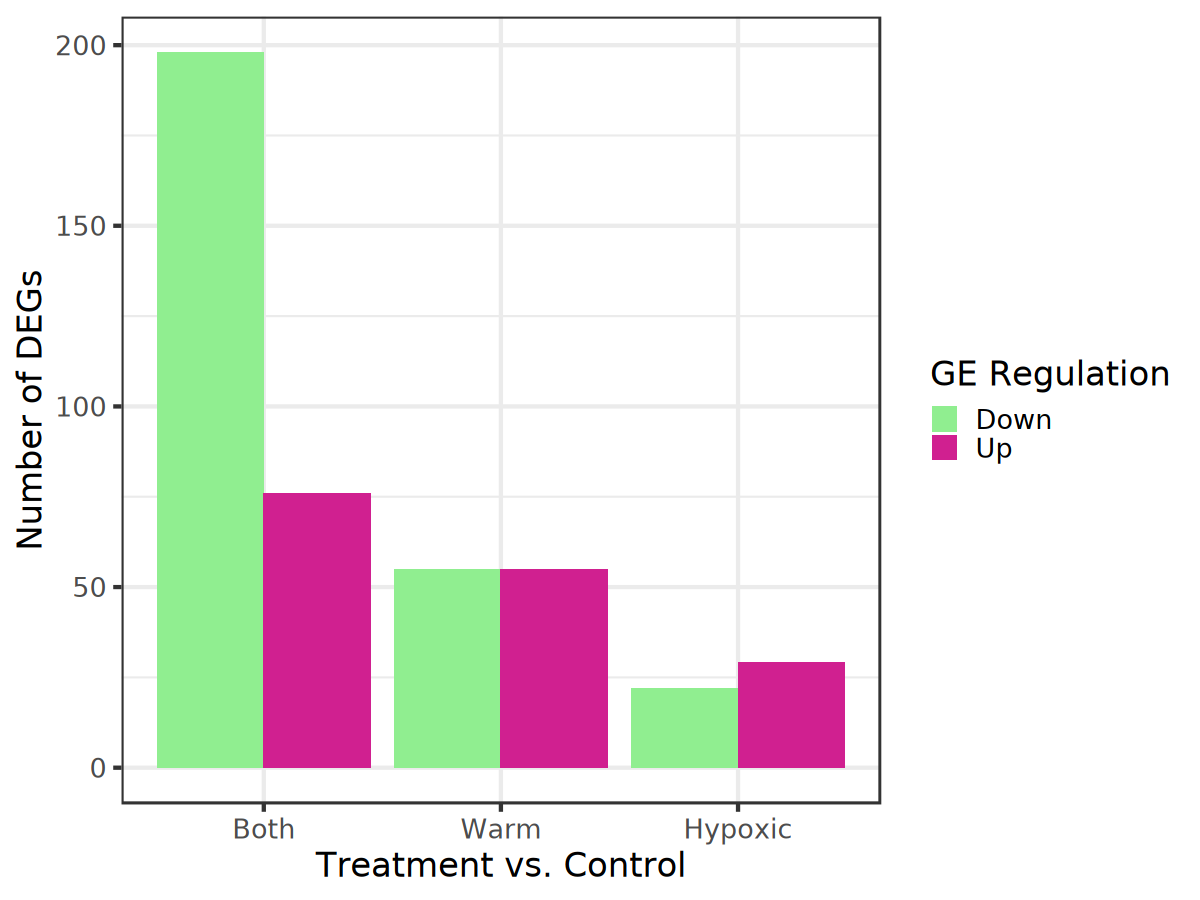

In [46]:
# change dimensions of output
options(repr.plot.width=10, repr.plot.height=7.5)

# reorder treatments
vs.cont.df$direction <- factor(vs.cont.df$direction, levels = c("Both", "Warm", "Hypoxic"))

# plot
vs.control.bar <- ggplot(vs.cont.df, aes(x = direction, 
                       y = n, fill = up_down)) +
geom_bar(stat = 'identity',
         position = position_dodge()) + 
scale_fill_manual(values=c('palegreen2', 'violetred')) +
theme_bw(base_size = 20) +
labs(fill = 'GE Regulation',
     x = 'Treatment vs. Control',
     y = 'Number of DEGs') 

vs.control.bar

**Observations**:
- B vs. C had the most DEGs, with the majority of those being down-regulated
- W vs. C have roughly 50:50 up- and down-regulated DEGs
- H vs. C resulted in the least amount of DEGs, with the *slight* majority of those being up-regulated

In [34]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/plots/vs.control_bar.pdf', vs.control.bar)

Saving 6.67 x 6.67 in image
